<a href="https://colab.research.google.com/github/aballiet/ML-Organ-Detection-CT-Scan/blob/dev/CNN_model_train_63.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

Importing all the stuff

In [0]:
from google.colab import drive # import drive from google colab

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os

Retrieving Data

In [0]:
# Mount Google Drive
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT, force_remount=True)          # we mount the google drive at /content/drive

In [0]:
%cd /content/
%mkdir dataset

/content


In [0]:
%cd /content/drive/My\ Drive/Projets/PIR/
!unzip dataset_63.zip -d /content/dataset

# Create Train Set

In [0]:
%cd /content/
patients = os.listdir('dataset')
%mkdir train_set
%mkdir test_set

/content


In [0]:
def movePatients(trainList, testList):
  for patient in patients:
    if patient in trainList:
      os.system('rsync -aP /content/dataset/'+patient+'/* /content/train_set/')
      print('-- patient :' + patient + ' added to train set')
    if patient in testList:
      os.system('rsync -a /content/dataset/'+patient+'/* /content/test_set/')
      print('** patient :' + patient + ' added to test set')


In [0]:
trainList = ['patient_' + str(i) for i in range(14)]
testList = ['patient_16', 'patient_17', 'patient_18']
movePatients(trainList, testList)

-- patient :patient_10 added to train set
-- patient :patient_13 added to train set
-- patient :patient_9 added to train set
** patient :patient_17 added to test set
-- patient :patient_5 added to train set
-- patient :patient_8 added to train set
-- patient :patient_1 added to train set
-- patient :patient_4 added to train set
-- patient :patient_3 added to train set
-- patient :patient_12 added to train set
-- patient :patient_11 added to train set
-- patient :patient_6 added to train set
** patient :patient_18 added to test set
-- patient :patient_7 added to train set
-- patient :patient_2 added to train set
-- patient :patient_0 added to train set
** patient :patient_16 added to test set


# Checking data

In [0]:
labels = ['adrenal_gland_left',
'adrenal_gland_rigth',
'aorta',
'background',
'body_envelope',
'first_lumbar_vertebra',
'gallbladder',
'kidney_left',
'kidney_right',
'liver',
'lung_left',
'lung_right',
'muscle_body_of_left_rectus_abdominis',
'muscle_body_of_right_rectus_abdominis',
'pancreas',
'psoas_major_left',
'psoas_major_right',
'spleen',
'sternum',
'thorax-abdomen',
'thyroid_gland',
'trachea',
'urinary_bladder']

base_dir = '/content/train_set'

for label in labels:
  temp_path = os.path.join(base_dir, label)
  print(label + "images: ", len(os.listdir(temp_path)))

adrenal_gland_leftimages:  6000
adrenal_gland_rigthimages:  5500
aortaimages:  7000
backgroundimages:  6986
body_envelopeimages:  7000
first_lumbar_vertebraimages:  7000
gallbladderimages:  7000
kidney_leftimages:  7000
kidney_rightimages:  7000
liverimages:  7000
lung_leftimages:  7000
lung_rightimages:  7000
muscle_body_of_left_rectus_abdominisimages:  7000
muscle_body_of_right_rectus_abdominisimages:  7000
pancreasimages:  6500
psoas_major_leftimages:  7000
psoas_major_rightimages:  7000
spleenimages:  7000
sternumimages:  7000
thorax-abdomenimages:  7000
thyroid_glandimages:  5500
tracheaimages:  7000
urinary_bladderimages:  7000


# Create Train & Test sets

In [0]:
batch_size = 1000

train_set_dir = '/content/train_set'
test_set_dir = '/content/test_set'

datagen = ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_set_dir,
    target_size=(63, 63),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    subset='training',) # set as training data

validation_generator = datagen.flow_from_directory(
    train_set_dir, # same directory as training data
    target_size=(63, 63),
    batch_size=batch_size,
    #early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto'),
    class_mode='categorical', #Determines the type of label arrays that are returned:"categorical" will be 2D one-hot encoded labels,
    shuffle=True,
    color_mode='grayscale',
    subset='validation') # set as validation data
print(train_generator.class_indices)
print(validation_generator.classes)

Found 125189 images belonging to 23 classes.
Found 31297 images belonging to 23 classes.
{'adrenal_gland_left': 0, 'adrenal_gland_rigth': 1, 'aorta': 2, 'background': 3, 'body_envelope': 4, 'first_lumbar_vertebra': 5, 'gallbladder': 6, 'kidney_left': 7, 'kidney_right': 8, 'liver': 9, 'lung_left': 10, 'lung_right': 11, 'muscle_body_of_left_rectus_abdominis': 12, 'muscle_body_of_right_rectus_abdominis': 13, 'pancreas': 14, 'psoas_major_left': 15, 'psoas_major_right': 16, 'spleen': 17, 'sternum': 18, 'thorax-abdomen': 19, 'thyroid_gland': 20, 'trachea': 21, 'urinary_bladder': 22}
[ 0  0  0 ... 22 22 22]


Create model

In [0]:
sample_training_images, y_truth = next(train_generator)
sample_training_images.shape

(1000, 63, 63, 1)

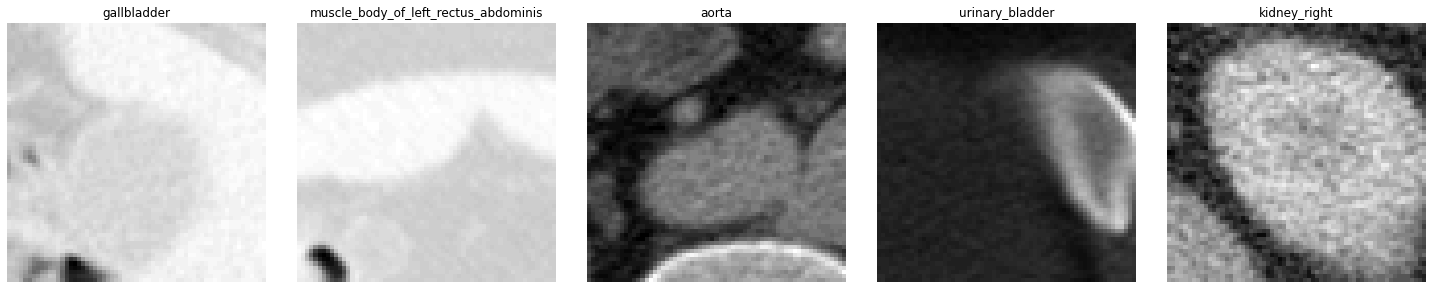

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    index = 0
    for img, ax in zip( images_arr, axes):

      # remove last dimension (1) of the image to make it work with grayscale img
      img = np.squeeze(img)

      ax.set_title(labels[np.argmax(y_truth[index])])
      ax.imshow(img, cmap="gray")
      ax.axis('off')
      index += 1
    plt.tight_layout()
    plt.show()


plotImages(sample_training_images[:5])


In [0]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3,3), padding="valid", activation='relu', input_shape=(63, 63, 1), kernel_regularizer=l2(0.001), strides=(2, 2)),
    Conv2D(64, (3,3) , padding="same", activation="relu", kernel_regularizer=l2(0.001), strides=(2, 2)),
    Conv2D(128, (3,3) , padding="same", activation="relu", kernel_regularizer=l2(0.001), strides=(2, 2)),
    Flatten(),
    Dense(800),
    Dropout(0.25),
    Dense(84),
    Dense(23, activation='softmax'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 31, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 800)               6554400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
%tensorboard --logdir {logs_base_dir}

Train Model

In [0]:
model.compile(optimizer='adam',
              loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
epochs = 100 #will stop earlier with EarlyStopping callback
steps_per_epoch = 50
validation_steps = 10

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/100
50/50 [==============================] - 22s 434ms/step - loss: 2.9424 - accuracy: 0.3511 - val_loss: 2.8601 - val_accuracy: 0.4055
Epoch 2/100
50/50 [==============================] - 22s 436ms/step - loss: 2.7236 - accuracy: 0.5353 - val_loss: 2.7275 - val_accuracy: 0.5252
Epoch 3/100
50/50 [==============================] - 21s 426ms/step - loss: 2.6247 - accuracy: 0.6267 - val_loss: 2.6616 - val_accuracy: 0.5874
Epoch 4/100
50/50 [==============================] - 22s 432ms/step - loss: 2.5507 - accuracy: 0.6970 - val_loss: 2.6156 - val_accuracy: 0.6294
Epoch 5/100
50/50 [==============================] - 21s 425ms/step - loss: 2.5060 - accuracy: 0.7390 - val_loss: 2.5867 - val_accuracy: 0.6545
Epoch 6/100
50/50 [==============================] - 21s 424ms/step - loss: 2.4717 - accuracy: 0.7727 - val_loss: 2.5741 - val_accuracy: 0.6680
Epoch 7/100
50/50 [==============================] - 22s 441ms/step - loss: 2.4517 - accuracy: 0.7916 - val_loss: 2.5365 - val_accuracy:

In [0]:
%cd /content/drive/My\ Drive/Projets/PIR/

tf.keras.models.save_model(
    model, 'Size_63_epoch_25_range_14_conv_3_regularized_dropout.keras', overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None
)

/content/drive/My Drive/Projets/PIR


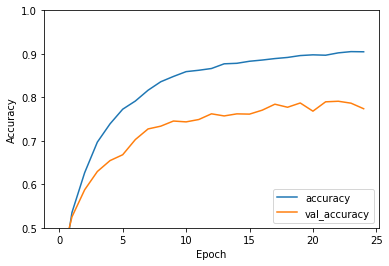

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
#plt.savefig('graph_range_18_new_modelB')

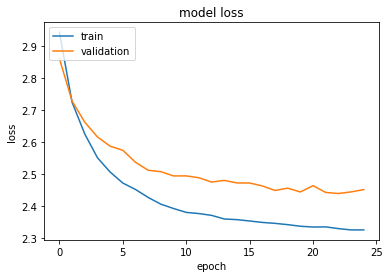

In [0]:
# Plot training & validation accuracy values
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
%cd /content/drive/My\ Drive/Projets/PIR/
!unzip patient_4.zip -d /content/temp/dataset

In [0]:
batch_size = 20000
 
test_generator = datagen.flow_from_directory(
    test_set_dir,
    target_size=(63, 63),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    subset='training') # set as training data

test_x, test_y = next(test_generator)

test_x.shape

Found 25598 images belonging to 23 classes.


(20000, 63, 63, 1)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(11,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
results = model.predict(test_x)
# convert from class probabilities to actual class predictions
predicted_classes = np.argmax(results, axis=1)
rounded_y = np.argmax(test_y, axis=1)

Normalized confusion matrix


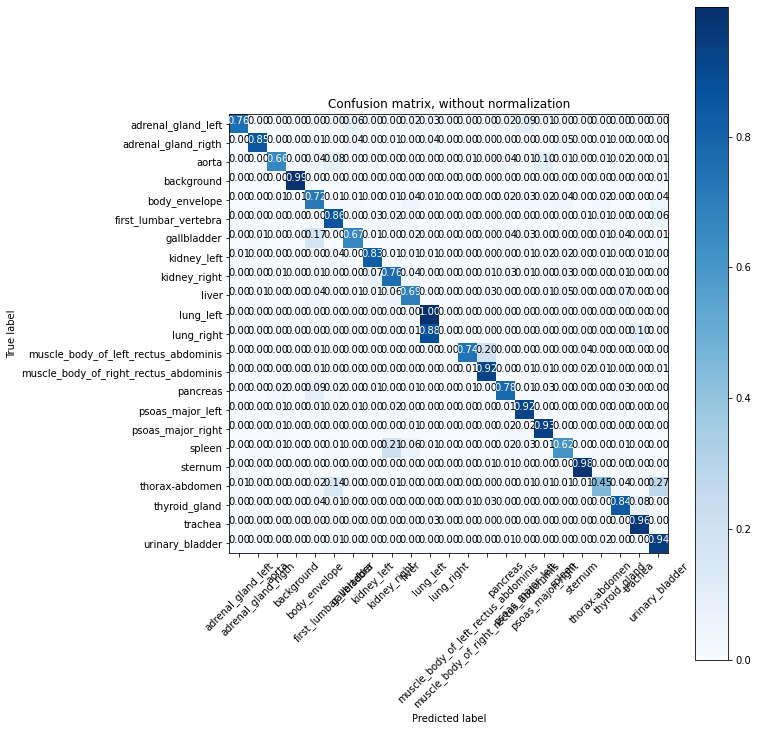

In [0]:
# Generate the confusion matrix
cnf_matrix = confusion_matrix(rounded_y, predicted_classes)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=True, title='Confusion matrix, without normalization')